## Import Packages

In [32]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
 
import warnings
warnings.filterwarnings("ignore")

#### `Read` the File & `Extract` the value & save make the `df`

In [33]:
# Read the file
with open("prices.txt", 'r') as f:
    # save the content of this file in variable
    content = f.read().strip()

# Extract the date and price values from the content variable as a list
date = [date.split(",")[0] for date in content.split("\n")][1:]
price = [price.split(",")[1] for price in content.split("\n")][1:]

In [34]:
# Make the dataframe
df = pd.DataFrame({"Date": date,"Price":price})

# Set the Date features as the index
df = df.set_index("Date")

# Make the prices feature as float data type
df["Price"] = df['Price'].astype(float)

# Make the data feature as a datetime data type
df.index = pd.to_datetime(df.index)

# Save the dataframe as csv file
df.to_csv("prices.csv", index=True)

df

,Price
Date,
2017-02-21,55.478001
2017-02-22,54.702000
2017-02-23,51.198002
2017-02-24,51.400002
2017-02-27,49.245998
...,...
2022-02-11,860.000000
2022-02-14,875.760010
2022-02-15,922.429993


#### Plot the Data

<AxesSubplot:title={'center':'Stock Price'}, xlabel='Date'>

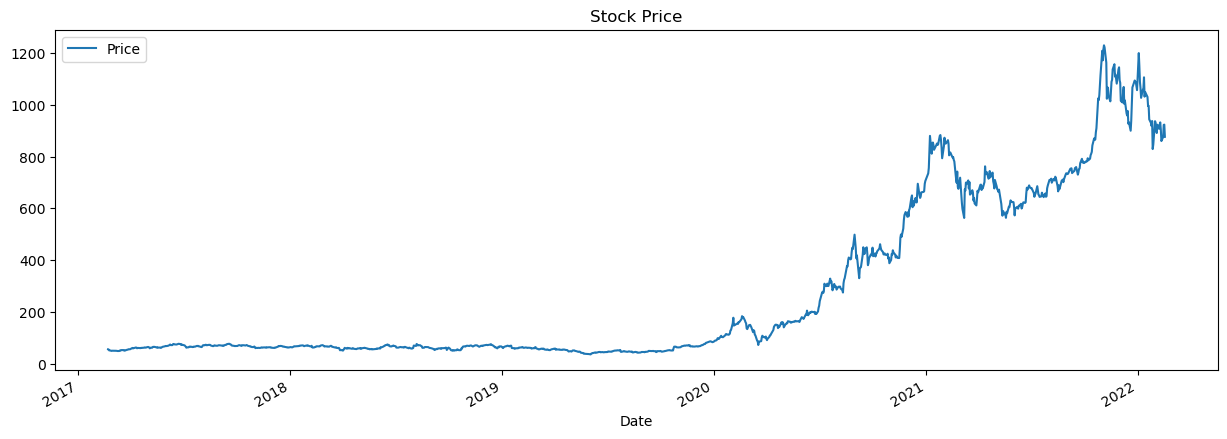

In [35]:
df.plot(style = '-',
        figsize=(15,5),
        title = "Stock Price")

#### Prepare the Data and Split it

In [36]:
# Take the value of 80% of the data
split_ind = int(len(df.index) * 0.8)
df.index[split_ind]

Timestamp('2021-02-22 00:00:00')

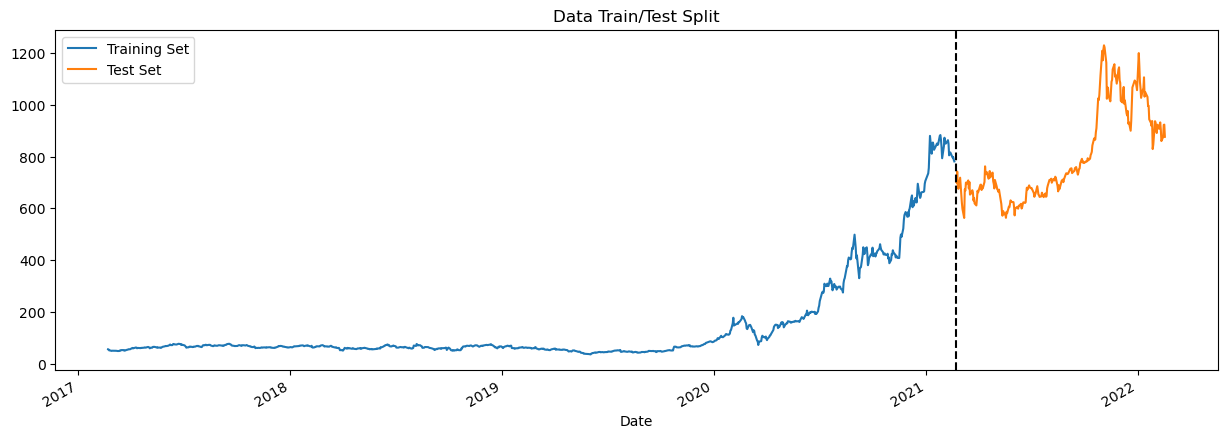

In [37]:
# Split the data into Training and Testing sets
train = df.loc[df.index < "2021-02-22"]
test = df.loc[df.index >= "2021-02-22"]

# plot the training and testing data
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label= "Training Set", title = "Data Train/Test Split")
test.plot(ax=ax, label= "Test Set", )
ax.axvline("2021-02-22", color='black', ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

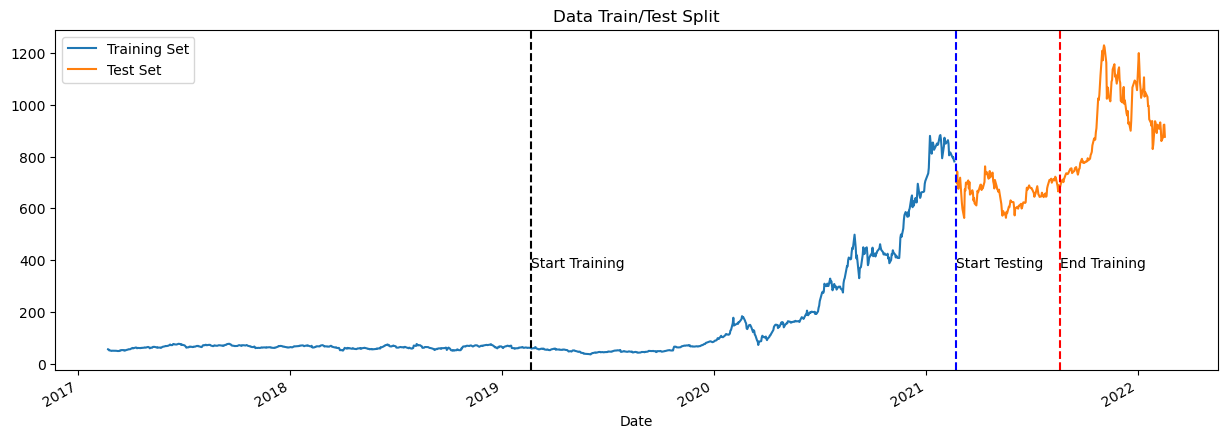

In [53]:
# plot the training and testing data
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label= "Training Set", title = "Data Train/Test Split")
test.plot(ax=ax, label= "Test Set", )
trans = ax.get_xaxis_transform()

ax.axvline("2019-02-21", color='black', ls='--')
plt.text("2019-02-21", .3, 'Start Training', transform=trans)

ax.axvline("2021-08-20", color='red', ls='--')
plt.text("2021-08-20", .3, 'End Training', transform=trans)

ax.axvline("2021-02-22", color='blue', ls='--')
plt.text("2021-02-22", .3, 'Start Testing', transform=trans)

ax.legend(['Training Set','Test Set'])
plt.show()


#### Create Features

In [18]:
def create_features(df):

    """
    Create time series features based on time series index.

    Arg:
        df: the dataframe that this function will create features based on its values
    """

    # Make copy on the data
    df = df.copy()
    
    # Create the features
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    # return the df
    return df       

# create features for the df
df_feat = create_features(df)

df_feat

,Price,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2017-02-21,55.478001,1,1,2,2017,52,21,8
2017-02-22,54.702000,2,1,2,2017,53,22,8
2017-02-23,51.198002,3,1,2,2017,54,23,8
2017-02-24,51.400002,4,1,2,2017,55,24,8
2017-02-27,49.245998,0,1,2,2017,58,27,9
...,...,...,...,...,...,...,...,...
2022-02-11,860.000000,4,1,2,2022,42,11,6
2022-02-14,875.760010,0,1,2,2022,45,14,7
2022-02-15,922.429993,1,1,2,2022,46,15,7


#### Plot the data with the features

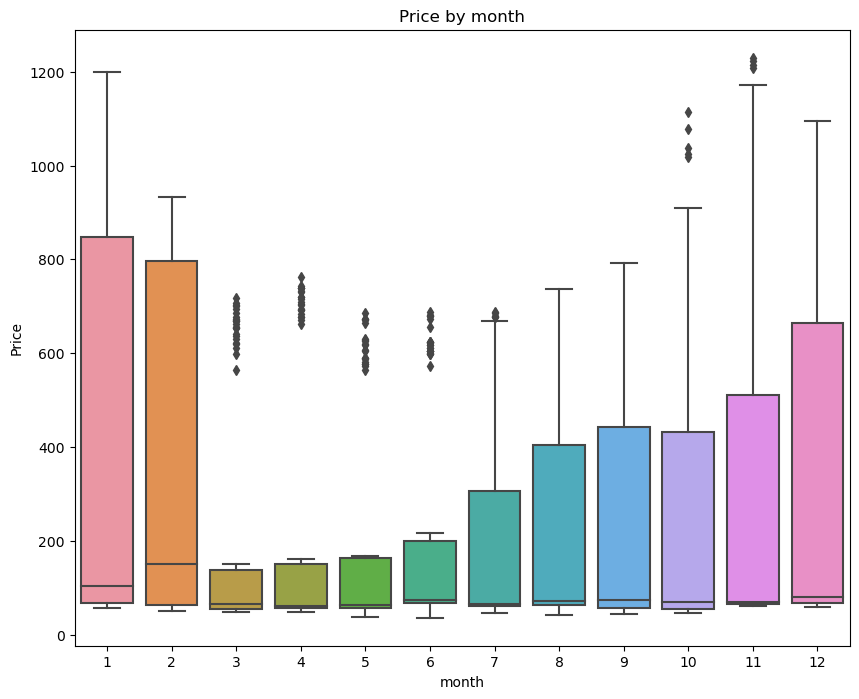

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_feat, x='month', y='Price')
ax.set_title('Price by month')
plt.show()

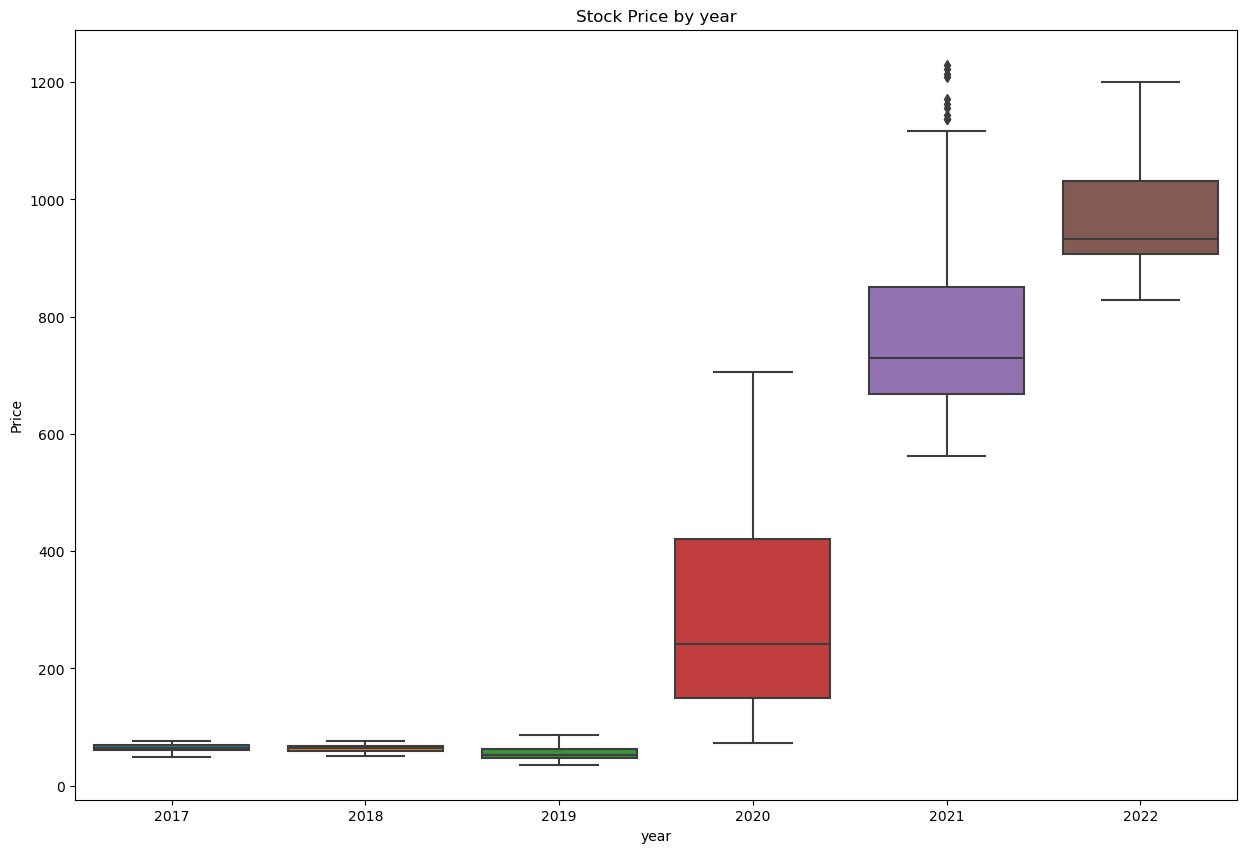

In [20]:
fig, ax = plt.subplots(figsize= (15,10))
sns.boxplot(data=df_feat, x='year', y='Price')
ax.set_title("Stock Price by year")
plt.show()

As we can see, the prices keep to increase while the year increase

In [21]:
# Make the features for the train and test data
train = create_features(train)
test = create_features(test)

# Define the features and target names
feat = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear','dayofmonth', 'weekofyear']
target = ['Price']

# Prepare the train dataset
X_train = train[feat]
y_train = train[target]

# Prepare the test dataset
X_test = test[feat]
y_test = test[target]

X_train["weekofyear"] = X_train["weekofyear"].astype(int)
X_test["weekofyear"] = X_test["weekofyear"].astype(int)

#### Build the model

In [22]:
# Build the Model
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01,max_depth=2,min_child_weight=0.1,early_stopping_rounds=50, reg_lambda=0.1,alpha=1, eval_metric='mae')

# Train the Model
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=10)

[0]	validation_0-mae:141.60641	validation_1-mae:789.71184
[10]	validation_0-mae:128.07775	validation_1-mae:711.60357
[20]	validation_0-mae:115.84161	validation_1-mae:640.94225
[30]	validation_0-mae:104.78588	validation_1-mae:577.01796
[40]	validation_0-mae:95.03186	validation_1-mae:519.18832
[50]	validation_0-mae:86.90518	validation_1-mae:472.43378
[60]	validation_0-mae:79.97344	validation_1-mae:431.81560
[70]	validation_0-mae:74.02477	validation_1-mae:386.76500
[80]	validation_0-mae:69.11923	validation_1-mae:346.00685
[90]	validation_0-mae:65.29081	validation_1-mae:309.13221
[100]	validation_0-mae:61.23766	validation_1-mae:279.33832
[110]	validation_0-mae:57.30961	validation_1-mae:253.55882
[120]	validation_0-mae:53.63098	validation_1-mae:230.64052
[130]	validation_0-mae:50.56817	validation_1-mae:209.97602
[140]	validation_0-mae:47.86091	validation_1-mae:192.43346
[150]	validation_0-mae:45.47597	validation_1-mae:176.61055
[160]	validation_0-mae:43.47931	validation_1-mae:162.82785
[170

XGBRegressor(alpha=1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=0.1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

#### Evaluate the Model

In [23]:
# Predictions for training and testing sets
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# RMSE & MAE for Training set
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# RMSE & MAE for Testing set
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Print the values
print(f"For the Training data, the RMSE: {rmse_train:.2f} and the MAE: {mae_train:.2f}")
print(f"For the Testing data, the RMSE: {rmse_test:.2f} and the MAE: {mae_test:.2f}")

For the Training data, the RMSE: 62.72 and the MAE: 34.01
For the Testing data, the RMSE: 166.59 and the MAE: 118.24


#### `Feature Importances` for the Model

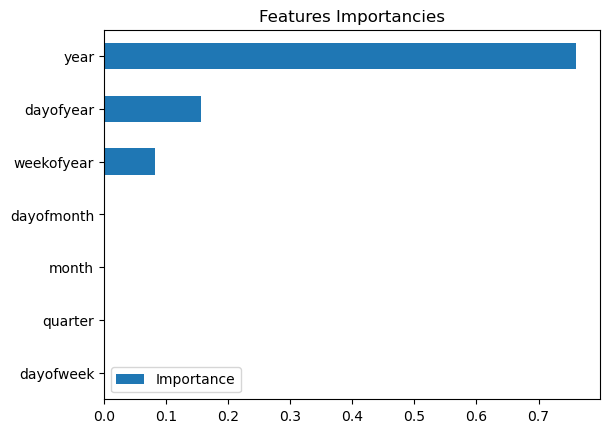

In [24]:
# make a dataframe of the importances
fi = pd.DataFrame( model.feature_importances_, index=model.feature_names_in_ , columns=["Importance"])

# sort the dataframe
fi.sort_values("Importance").plot(kind='barh', title="Features Importancies")

# show the plot
plt.show()

#### Plot Predictions for the test data

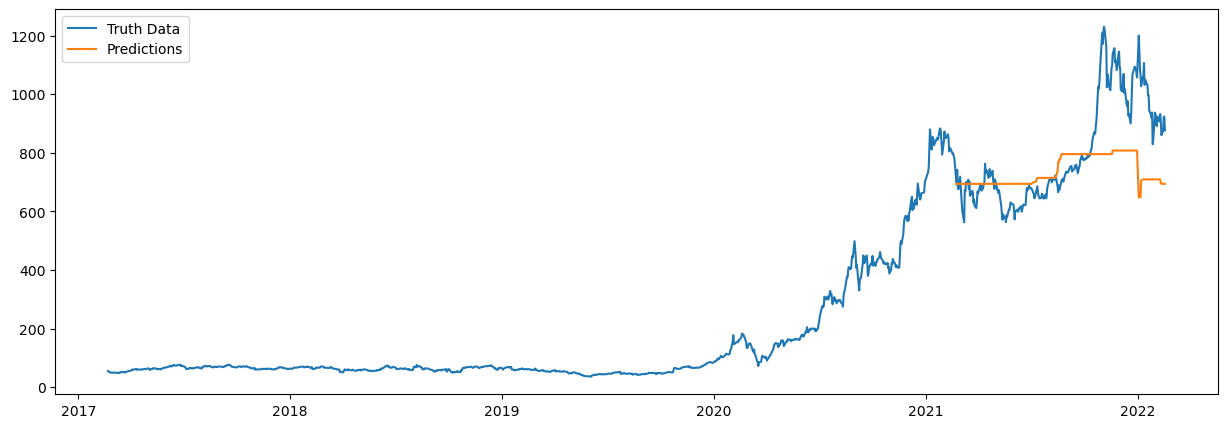

In [25]:
plt.figure(figsize=(15, 5))

plt.plot(df.index, df['Price'],'-')
plt.plot(test.index, y_pred_test,"-")

plt.legend(["Truth Data", "Predictions"])
ax.set_title("Raw Data and Predictions")

plt.show()